# The Future of Basketball Players

## Set up environment

In [1]:
# Load modules
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport
import random
from statistics import mode

## Get data

In [84]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import and inspect training data
df_train = pd.read_csv('../../data/raw/train.csv')
#display(df_train)

# Import and inspect test data
df_test = pd.read_csv('../../data/raw/test.csv')
#display(df_test)

## Check data

### Data dictionary

In [85]:
# Copied from https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG%": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P%": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT%": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

### Data exploration

## Experimentation

### Feature engineering

In [86]:
# Convert negative values to absolute values
df_train = abs(df_train)
df_test = abs(df_test)

In [87]:
# Attempt 5: Add Hollinger's Player Efficiency Ratings
# Adapted from https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess
train_per = ((df_train['FGM']*85.910)+ 
(df_train['STL']*53.897)+ 
(df_train['3P_Made']*51.757)+ 
(df_train['FTM']*46.845)+
(df_train['BLK']*39.190)+
(df_train['OREB']*39.190)+
(df_train['AST']*34.667)+
(df_train['DREB']*14.707)-
((df_train['FTA']-df_train['FTM'])*20.091)-
((df_train['FGA']-df_train['FGM'])*39.190)-
(df_train['TOV']*53.897))*(1/df_train['MIN'])

test_per = ((df_test['FGM']*85.910)+ 
(df_test['STL']*53.897)+ 
(df_test['3P_Made']*51.757)+ 
(df_test['FTM']*46.845)+
(df_test['BLK']*39.190)+
(df_test['OREB']*39.190)+
(df_test['AST']*34.667)+
(df_test['DREB']*14.707)-
((df_test['FTA']-df_test['FTM'])*20.091)-
((df_test['FGA']-df_test['FGM'])*39.190)-
(df_test['TOV']*53.897))*(1/df_test['MIN'])

df_train.insert(21, 'PER', train_per)
df_test.insert(21, 'PER', test_per)

### Data manipulation

In [88]:
# Drop ID column - training and test data
df_train = df_train.drop(['Id_old','Id'], axis=1)
df_test = df_test.drop(['Id_old','Id'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features - training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Standardize features - test data
X_test = scaler.fit_transform(df_test)

# Save scaler into models folder
dump(scaler, '../../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.1, random_state=8)

# Resample training data if required
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### Save data objects

In [ ]:
# Save data objects into folder
dump(scaler, '../../models/David/scaler.joblib')
dump(X_train, '../../data/processed/David/X_train.joblib')
dump(X_val, '../../data/processed/David/X_val.joblib')
dump(y_train, '../../data/processed/David/y_train.joblib')
dump(y_val, '../../data/processed/David/y_val.joblib')

### Set up experiment space

In [7]:
# Set dataframe for score dumps
pred_scor = pd.DataFrame(
        { "name": []
        , "auc": []
        , "sens": []
        , "spec": []
        , "f1": []
        }
    )

In [8]:
# Define function to fit and save models, and run predictions on validation data
def fit_predict_save(reg, name, X_train, y_train, X_val, y_val):
    
    """
    Args:
        reg: Classifier with parameters defined.
        name: Name given to model (to be saved to .joblib file)
        X_train: Numpy array of input values in training data
        y_train: Numpy array of actual target values in training data
        X_val: Numpy array of input values in validation data
        y_val: Numpy array of actual target values in validation data
    """
    
    # Fit classifier
    reg.fit(X_train, y_train)
    
    global y_train_pred, y_val_pred, y_val_prob
    
    # Model predictions on training and validation data
    y_train_pred = reg.predict(X_train)
    y_val_pred = reg.predict(X_val)
    y_val_prob = reg.predict_proba(X_val)[:,1]
    
    # Save fitted model into model folder
    save_path = ('../../models/David/'"%s"'.joblib' % name) 
    dump(reg, save_path)
    
    # Calculate AUC
    roc_auc_val = roc_auc_score(y_val, y_val_prob)
    print("\nROC_AUC:", roc_auc_val, "\n")
    
    return None

In [9]:
# Define function to plot confidence matrix and ROC curve for model evaluation
def plot_cm_roc(reg, X_val, y_val):
    
    """
    Args:
        reg: Fitted classifier.
        X_val: Numpy array of input values in validation data.
        y_val: Numpy array of actual target values in validation data.
    """
    
    # Print confusion matrix (standard and normalized formats)
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(121) 
    ax1.title.set_text("Confusion matrix-Training (normalized)")
    plot_confusion_matrix(reg, X_train, y_train, 
                          cmap=plt.cm.Oranges,
                          colorbar=False,
                          normalize='true',
                          ax=ax1)

    ax2 = fig.add_subplot(122)
    ax2.title.set_text("Confusion matrix-Validation (normalized)")
    plot_confusion_matrix(reg, X_val, y_val,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true',
                          ax=ax2)

    plt.subplots_adjust(wspace=0.5)
    plt.show() 
    
    # Plot ROC curve
    plot_roc_curve(reg, X_val, y_val)
    plt.plot([0, 1], [0, 1],'r--')
    plt.title("Receiver Operating Characteristic")
    plt.show()
    
    return None 

In [10]:
# Define function to save model performance to a dataframe
def save_perf \
    (  name
     , y_val:np.real
     , y_val_pred:np.real
     , y_val_prob:np.real
     , overwrite:bool=True
     , print_dataframe: bool=True
     , save_dataframe:bool=True
    ):
    
    """
    Args:
        name: Name of model (to be saved to output table).
        y_val: Numpy array of actual target values in validation data.
        y_val_pred: Numpy array of target values predicted by model.
        y_val_prob: Numpy array of probability estimates for target values predicted by model.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe.
        save_dataframe (bool, optional): Whether or not to save the updated dataframe to disk as .csv file.
    """

    # Import modules
    from sklearn.metrics import roc_curve, auc, confusion_matrix
    from sklearn.metrics import f1_score as f1
    
    # Define and calculate metrics
    fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
    val_auc = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(y_val,y_val_pred), 5)
    
    global pred_scor
    
    df = pred_scor

    # Two different methods of updating the table
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        
        df = pred_scor.append(new)
       
    # Fix Pandas indexes
    df.sort_values(by=['auc'], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    

    # Assign back to the global scope
    pred_scor = df
    
    if print_dataframe:
        display(df)
        
    if save_dataframe:
        df.to_csv("../../models/David/experiment_results.csv")
    
    return None

### Modelling

#### Baseline

In [11]:
# Generate actuals
actuals = np.array(df_train['TARGET_5Yrs'])

# Generate baseline, based on mode of target class
random.seed(123)
baseline = np.full(actuals.shape, mode(actuals))

# Check performance
save_perf("Baseline", actuals, baseline, baseline)

c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,name,auc,sens,spec,f1
0,Baseline,0.5,1.0,0.0,0.90926


#### Logistic Regression - CV

In [ ]:
# Create classifier
from sklearn.linear_model import LogisticRegressionCV 

C_list = np.linspace(0.001, 0.5, 20)

reg = LogisticRegressionCV(
    Cs=C_list, 
    cv=20,
    penalty='l1',
    scoring='roc_auc', 
    solver='liblinear',
    tol=1e-4, 
    max_iter=1000, 
    class_weight='balanced', 
    n_jobs=10,
    verbose=2, 
    refit=True, 
    multi_class='ovr', 
    random_state=42)

In [ ]:
fit_predict_save(reg, 'log_reg_cv_fe5', X_train, y_train, X_val, y_val)

In [ ]:
plot_cm_roc(reg, X_val, y_val)

In [ ]:
save_perf('log_reg_cv_fe5', y_val, y_val_pred, y_val_prob)

#### XGBoost

In [12]:
# Create classifier
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

reg = xgb.XGBClassifier(objective ='reg:squarederror', 
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1,
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 10)

In [13]:
fit_predict_save(reg, 'xgb', X_train, y_train, X_val, y_val)


ROC_AUC: 0.6969465913423214 



c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


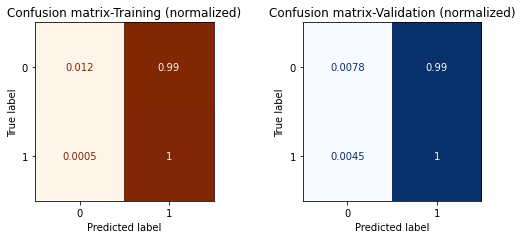

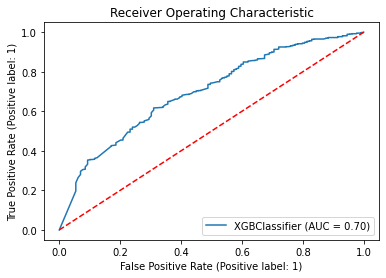

In [14]:
plot_cm_roc(reg, X_val, y_val)

In [15]:
save_perf('xgb', y_val, y_val_pred, y_val_prob)

,name,auc,sens,spec,f1
0,xgb,0.696947,0.99553,0.00775,0.91070
1,Baseline,0.500000,1.00000,0.00000,0.90926


#### Hyperparameter tuning

In [19]:
#Optimise using hyperopt
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
}

def objective(space):
    from sklearn.model_selection import cross_val_score
    
    reg = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        use_label_encoder=False,
        #eval_metric=binary:logistic
    )
    
    acc = cross_val_score(reg, X_train, y_train, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)

print("Best: ", best)

[21:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [38]:
# Model with hypoeropt parameters

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

reg = xgb.XGBClassifier(objective ='binary:logistic', 
                        colsample_bytree = 0.85, 
                        learning_rate = 0.05,
                        max_depth = 2,
                        min_child_weight=2,
                        subsample=0.7,
                        alpha = 10,
                        n_estimators = 10)

In [89]:
# Cross-validated alternative

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import f1_score

clf_xgb = XGBClassifier(objective = 'binary:logistic')

param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.001, 0.01),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [2, 3],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3],
              'lambda': [1, 2, 3],
              'alpha': [0,1,2],
              'gamma':[0,1,2]
             }

reg = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist, 
                         n_iter = 20, 
                         scoring = 'roc_auc', 
                         verbose = 3, 
                         n_jobs = -1, 
                         cv=10)


In [90]:
fit_predict_save(reg, 'xgb_cv', X_train_res, y_train_res, X_val, y_val)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:36:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

ROC_AUC: 0.6879353966658579 



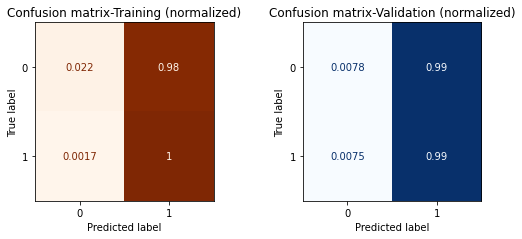

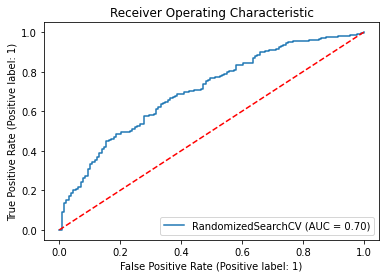

In [81]:
plot_cm_roc(reg, X_val, y_val)

### Model interpretation

#### Permutation

In [ ]:
# Variable importance by permutation
from mlxtend.evaluate import feature_importance_permutation

imp_vals, imp_all = feature_importance_permutation(predict_method = reg.predict,
                                             X = X_val,
                                             y = y_val,
                                             metric = 'accuracy',
                                             num_rounds = 10,
                                             seed = 1)

# Visualise (from user guide)
std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Feature importance via permutation importance w. std. dev.")
plt.bar(range(X_val.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X_val.shape[1]), indices)
plt.xlim([-1, X_val.shape[1]])
plt.show()

#### LIME

In [ ]:
import lime
import lime.lime_tabular

feature_names = list(df_train.columns[:-1])

explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=feature_names,
                                                   class_names=["0","1"],
                                                   mode='classification')

exp = explainer.explain_instance(X_val[15],
                                 reg.predict_proba,
                                 top_labels=1,
                                 num_features=20)

exp.show_in_notebook(show_all=False)

## Test

In [ ]:
# Predict target probabilities
test_probs = reg.predict_proba(X_test)[:,1]

In [ ]:
# Create dataframe object
test_probs_df = pd.DataFrame(test_probs, columns = ["TARGET_5Yrs"])

# Name 'ID' column
test_probs_df.index.name = "Id"

In [ ]:
# Save model predictions on test data to .csv for import into Kaggle
test_probs_df.to_csv("../../reports/David/kaggle_sub.csv")